In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
%matplotlib inline

reload(sys)  
sys.setdefaultencoding('utf8')

import statsmodels.api as sm


In [2]:
train = pd.read_csv("data/train_1.csv")
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
train.shape

(145063, 551)

In [4]:
train.Page.head()

0              2NE1_zh.wikipedia.org_all-access_spider
1               2PM_zh.wikipedia.org_all-access_spider
2                3C_zh.wikipedia.org_all-access_spider
3           4minute_zh.wikipedia.org_all-access_spider
4    52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
Name: Page, dtype: object

In [5]:
#split page column with '_' and take the last three values
metadata = pd.DataFrame((row.split('_')[-3:] for row in train.Page), columns=['host', 'access', 'agent'])
#get the lang part from 'zh.wikipedia.org'
metadata['lang'] = metadata.host.str.split('.').str.get(0)
metadata.head()

,host,access,agent,lang
0,zh.wikipedia.org,all-access,spider,zh
1,zh.wikipedia.org,all-access,spider,zh
2,zh.wikipedia.org,all-access,spider,zh
3,zh.wikipedia.org,all-access,spider,zh
4,zh.wikipedia.org,all-access,spider,zh


In [6]:
trainDF = pd.concat([train,metadata], axis=1)

## Analysis of Time Series according to languages

In [7]:
langDict = {}
langDict['zh'] = trainDF[trainDF.lang=='zh']
langDict['fr'] = trainDF[trainDF.lang=='fr']
langDict['en'] = trainDF[trainDF.lang=='en']
langDict['commons'] = trainDF[trainDF.lang=='commons']
langDict['ru'] = trainDF[trainDF.lang=='ru']
langDict['www'] = trainDF[trainDF.lang=='www']
langDict['de'] = trainDF[trainDF.lang=='de']
langDict['ja'] = trainDF[trainDF.lang=='ja']
langDict['es'] = trainDF[trainDF.lang=='es']

In [8]:
avg = {}
for key in langDict:
    avg[key] = pd.to_numeric(langDict[key].iloc[:,1:].sum(axis=0), errors='coerce')/ langDict[key].shape[0]
    #values for host, access and agent are NaN hence dropping them
    avg[key].dropna(inplace=True)
#     convert index to datetime
    avg[key].index = pd.to_datetime(avg[key].index)

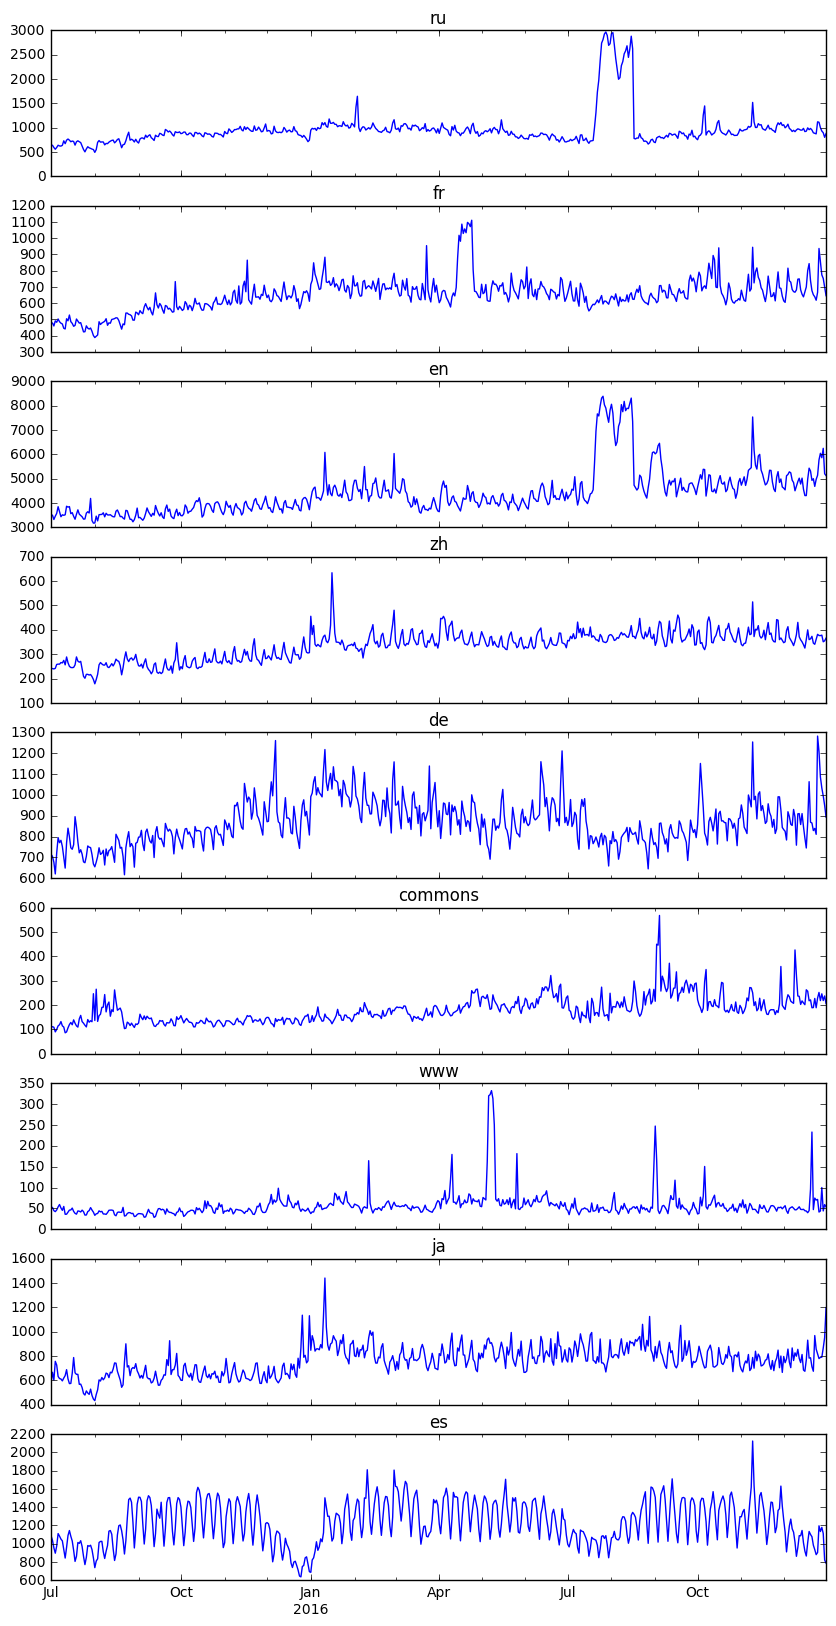

In [9]:
# plotting all TS plots seperately
fig, axs = plt.subplots(nrows=9, figsize=(10, 20), sharex=True)
for i, key in enumerate(avg):
    avg[key].plot(ax=axs[i])
    axs[i].set_title(key)



In [10]:
#Rolling window analysis for stationarity of series

def rollingAnalysis(timeseries, windowsize=10):
    rolmean = timeseries.rolling(window=windowsize, center=False).mean()
    rolstd = timeseries.rolling(window=windowsize, center=False).std()
    return rolmean, rolstd

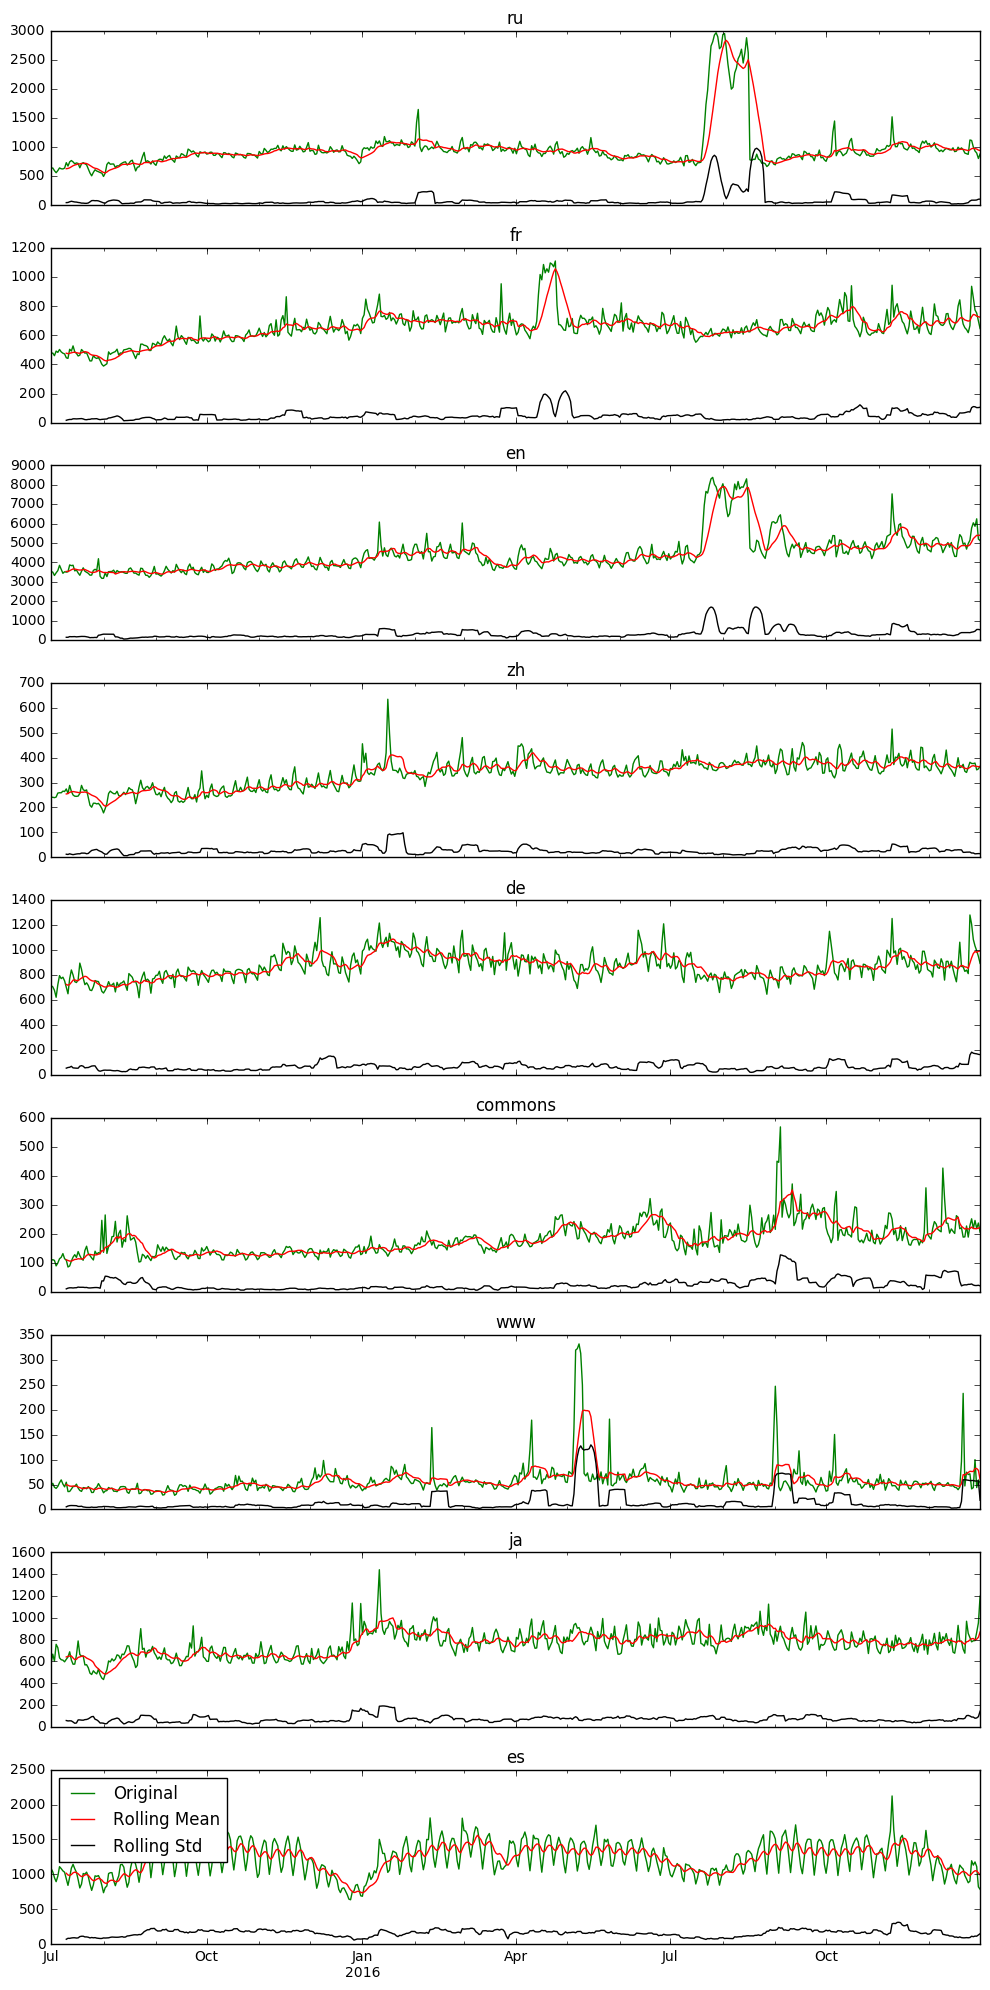

In [11]:
fig, axs = plt.subplots(nrows=9, figsize=(10, 20), sharex=True)
for i, key in enumerate(avg):
    rolmean, rolstd = rollingAnalysis(avg[key])
    avg[key].plot(ax=axs[i], color='green', label='Original')
    rolmean.plot(ax=axs[i], color='red', label='Rolling Mean')
    rolstd.plot(ax=axs[i], color='black', label='Rolling Std')
    axs[i].set_title(key)
    plt.legend(loc='best')
    plt.tight_layout()


In [12]:
""" We might not always be able to make a visual inferences whether
the time series is statinary hence we perform the augmented dickey fuller test for
stationarity of TS."""
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(avg['en'], autolag='AIC')
print "Results of Augmented Dickey Fuller Test for en"
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic',
                            'p-value',
                            '#Lags Used',
                            'Number of Observations Used'])

for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -2.247284
p-value                          0.189534
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (5%)             -2.866957
Critical Value (1%)             -3.442632
Critical Value (10%)            -2.569655
dtype: float64

 ##### if pvalue is significantly higher, so we cannot reject the Null Hypothesis hence we cannot reject that there is a unit root.
 ##### if the test statistic is more than 5% critical value, this will show that time series is not stationary 

In [13]:
# decomposition = sm.tsa.seasonal_decompose(avg['en'])
type(avg['en'])

pandas.core.series.Series

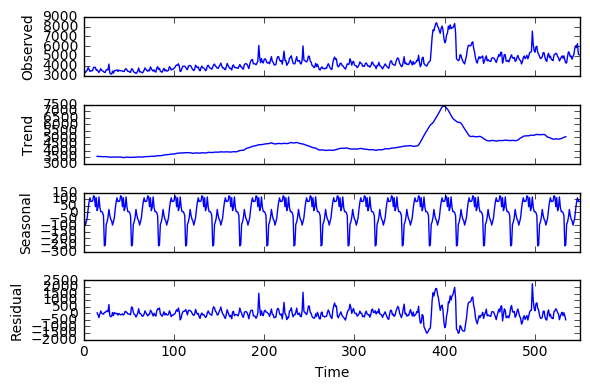

In [14]:
res = sm.tsa.seasonal_decompose(avg['en'].values, freq=30, model='additive')
resplot = res.plot()

In [15]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
autocorrelation = acf(avg['en'], nlags=100)
partial_autocorr = pacf(avg['en'])

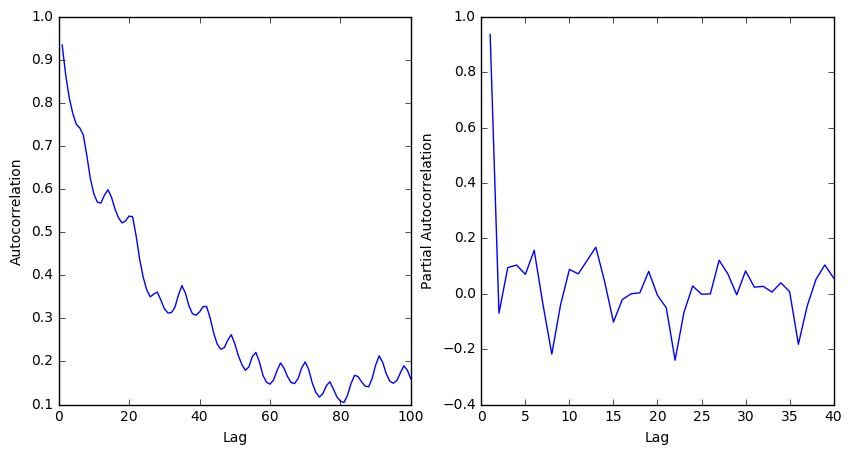

In [16]:
#the Acf is limited to 100 lags only in this case
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.plot(range(len(autocorrelation))[1:], autocorrelation[1:])
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax2.plot(range(len(partial_autocorr))[1:], partial_autocorr[1:])
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

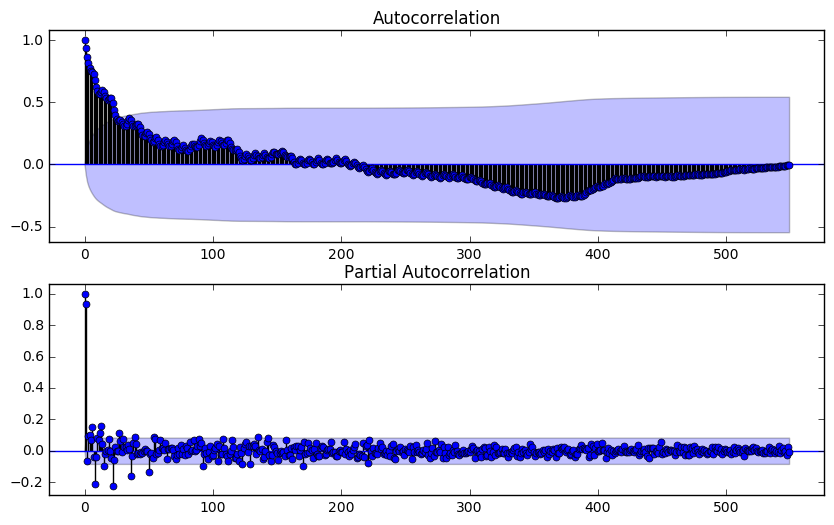

In [17]:
#the Acf is not limited to 100 lags in this case hence the different plot
from statsmodels.graphics import tsaplots
fig, axes = plt.subplots( 2, figsize=(10,6))
_ = tsaplots.plot_acf(avg['en'], axes[0])
_ = tsaplots.plot_pacf(avg['en'], axes[1])


As the ACF plot tails of and the PACF plot cuts off we will use the AR(p) model

reference from https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c    
In this plot, the 'p' and 'q' values can be determined as follows:   
p: The lag value where the PACF cuts off (drops to 0) for the first time. If you look closely, p=2.
q: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you look closely, q=1.
This means that the optimal values for the ARIMA(p,d,q) model are (2,1,1).
If your assessment of the ACF and PACF plots differs from the values suggested by the arma_order_select_ic function, you should plug in different values for the p and q terms and use the model fit results to study the AIC values and proceed with the model with a lower AIC value

In [18]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels
model = ARIMA(avg['en'], order=(1,2,0))
model_fit = model.fit()

In [19]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  548
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -4110.540
Method:                       css-mle   S.D. of innovations            437.850
Date:                Tue, 03 Oct 2017   AIC                           8227.080
Time:                        22:04:40   BIC                           8239.999
Sample:                    07-03-2015   HQIC                          8232.129
                         - 12-31-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.5458     13.235     -0.041      0.967       -26.486    25.394
ar.L1.D2.y    -0.4140      0.039    -10.615      0.000        -0.490    -0.338
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.4155           +0.0000j            2.4155            0.5000
-----------------------------------------------------------------------------
"""

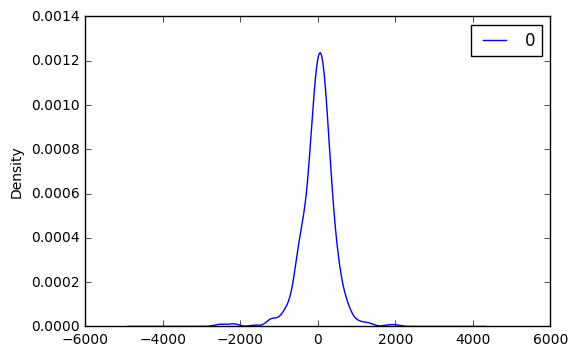

In [20]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')

In [21]:
avg['en'].shift().head(10)

2015-07-01            NaN
2015-07-02    3513.862203
2015-07-03    3502.511407
2015-07-04    3325.357889
2015-07-05    3462.054256
2015-07-06    3575.520035
2015-07-07    3849.736021
2015-07-08    3643.523063
2015-07-09    3437.871080
2015-07-10    3517.459391
dtype: float64

In [22]:
avg['en'].head(10)

2015-07-01    3513.862203
2015-07-02    3502.511407
2015-07-03    3325.357889
2015-07-04    3462.054256
2015-07-05    3575.520035
2015-07-06    3849.736021
2015-07-07    3643.523063
2015-07-08    3437.871080
2015-07-09    3517.459391
2015-07-10    3497.571594
dtype: float64

In [23]:
differencedEn= avg['en'] - avg['en'].shift()
differencedEn.head(10)

2015-07-01           NaN
2015-07-02    -11.350796
2015-07-03   -177.153518
2015-07-04    136.696366
2015-07-05    113.465779
2015-07-06    274.215986
2015-07-07   -206.212958
2015-07-08   -205.651983
2015-07-09     79.588311
2015-07-10    -19.887797
dtype: float64

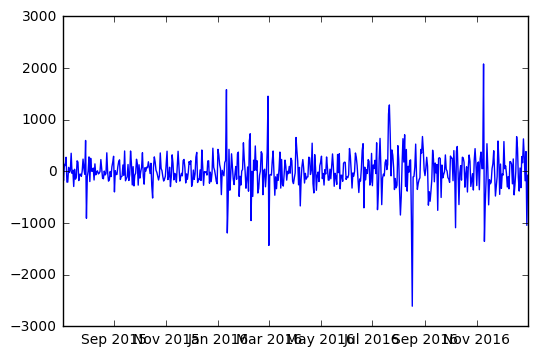

In [24]:
#use differencing to make ts stationary
differencedEn= avg['en'] - avg['en'].shift()
plt.plot(differencedEn)
# the time series looks pretty much stationary

In [25]:
differencedEn = differencedEn[1:] #removing first term as it is NaN

In [26]:
dftest = adfuller(differencedEn, autolag='AIC')
print "Results of Augmented Dickey Fuller Test for en"
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic',
                            'p-value',
                            '#Lags Used',
                            'Number of Observations Used'])

for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -8.254153e+00
p-value                        5.292475e-13
#Lags Used                     1.300000e+01
Number of Observations Used    5.350000e+02
Critical Value (5%)           -2.866957e+00
Critical Value (1%)           -3.442632e+00
Critical Value (10%)          -2.569655e+00
dtype: float64

as P value is far less than the significance level of 0.05 and test statistic is less than 1% critical value we can say that the the series is now stationary

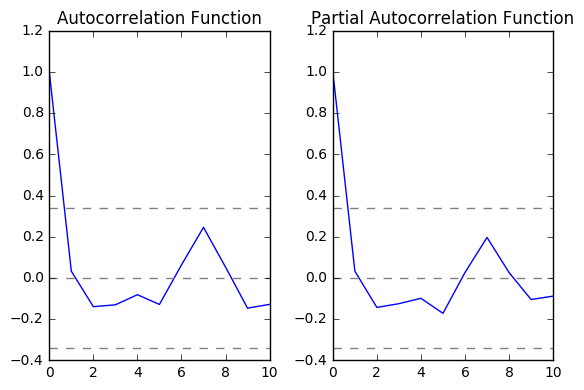

In [27]:
#ACF and PACF plots

lag_acf = acf(differencedEn, nlags=10)
lag_pacf = pacf(differencedEn, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(differencedEn)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(differencedEn)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(differencedEn)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(differencedEn)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

reference from https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c    
In this plot, the 'p' and 'q' values can be determined as follows:   
p: The lag value where the PACF cuts off (drops to 0) for the first time. If you look closely, p=1.
q: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you look closely, q=1.
This means that the optimal values for the ARIMA(p,d,q) model are (1,1,1).
If your assessment of the ACF and PACF plots differs from the values suggested by the arma_order_select_ic function, you should plug in different values for the p and q terms and use the model fit results to study the AIC values and proceed with the model with a lower AIC value

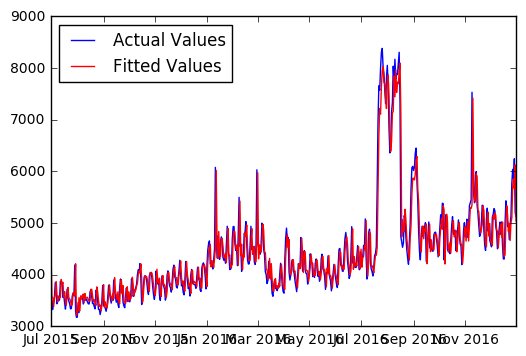

In [28]:
# AR(1 1 1) gives error
model = ARIMA(avg['en'], order=(3, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(avg['en'], label='Actual Values')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values')
plt.legend(loc='best')


In [29]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  550
Model:                     ARMA(3, 1)   Log Likelihood               -3978.051
Method:                       css-mle   S.D. of innovations            334.244
Date:                Tue, 03 Oct 2017   AIC                           7968.103
Time:                        22:04:43   BIC                           7993.962
Sample:                    07-01-2015   HQIC                          7978.208
                         - 12-31-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       4428.9201    294.415     15.043      0.000      3851.877  5005.963
ar.L1.y        1.6525      0.149     11.086      0.000         1.360     1.945
ar.L2.y       -0.8382      0.143     -5.850      0.000        -1.119    -0.557
ar.L3.y        0.1702      0.044      3.890      0.000         0.084     0.256
ma.L1.y       -0.6640      0.149     -4.466      0.000        -0.955    -0.373
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0324           -0.0000j            1.0324           -0.0000
AR.2            1.9460           -1.3797j            2.3855           -0.0982
AR.3            1.9460           +1.3797j            2.3855            0.0982
MA.1            1.5059           +0.0000j            1.5059            0.0000
-----------------------------------------------------------------------------
"""

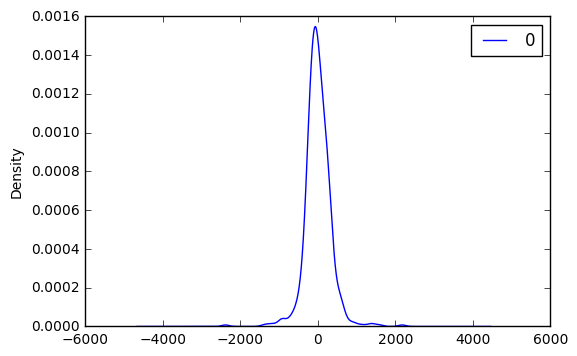

In [30]:
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')


In [31]:
residuals.describe()

,0
count,550.000000
mean,2.925710
std,336.543216
min,-2382.696112
25%,-168.148026
50%,-20.611129
75%,172.107229
max,2178.826413


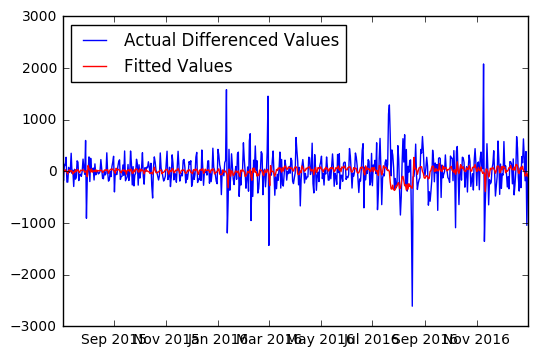

In [32]:
# AR(1 1 1) gives error
model = ARIMA(differencedEn, order=(3, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(differencedEn, label='Actual Differenced Values')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values')
plt.legend(loc='best')


In [33]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  549
Model:                     ARMA(3, 1)   Log Likelihood               -3970.776
Method:                       css-mle   S.D. of innovations            333.854
Date:                Tue, 03 Oct 2017   AIC                           7953.553
Time:                        22:04:45   BIC                           7979.401
Sample:                    07-02-2015   HQIC                          7963.655
                         - 12-31-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.6984      0.860      4.298      0.000         2.012     5.385
ar.L1.y        0.9855      0.042     23.191      0.000         0.902     1.069
ar.L2.y       -0.1761      0.059     -2.961      0.003        -0.293    -0.060
ar.L3.y        0.0914      0.043      2.134      0.033         0.007     0.175
ma.L1.y       -1.0000      0.005   -192.740      0.000        -1.010    -0.990
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           -0.0000j            1.1080           -0.0000
AR.2            0.4095           -3.1160j            3.1428           -0.2292
AR.3            0.4095           +3.1160j            3.1428            0.2292
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [34]:
pAR = []
diff = []
qMA = []
aic = []

for p in range(4):
    for d in range(2):
        for q in range(3):
            try:
                arima_mod=sm.tsa.ARIMA(differencedEn,(p,d,q)).fit(transparams=True)
                x =arima_mod.aic
            except:
                x = -1
            pAR.append(p)
            diff.append(d)
            qMA.append(q)
            aic.append(x)

In [35]:
# keys = pdq
# values = aic
# d = dict(zip(keys, values))
# print (d)

# minaic=min(d, key=d.get)

# for i in range(3):
#  p=minaic[0]
#     d=minaic[1]
#     q=minaic[2]
# print (p,d,q)
dataDict = {'p': pAR, 'd': diff, 'q':qMA, 'AIC':aic}
results = pd.DataFrame(dataDict)
results = results[['p', 'd', 'q', 'AIC']].sort('AIC')
results

,p,d,q,AIC
11,1,1,2,-1.000000
10,1,1,1,-1.000000
20,3,0,2,7892.755512
14,2,0,2,7895.136649
17,2,1,2,7952.466128
19,3,0,1,7953.552605
23,3,1,2,7954.435251
8,1,0,2,7956.299800
13,2,0,1,7956.349643
7,1,0,1,7958.254176


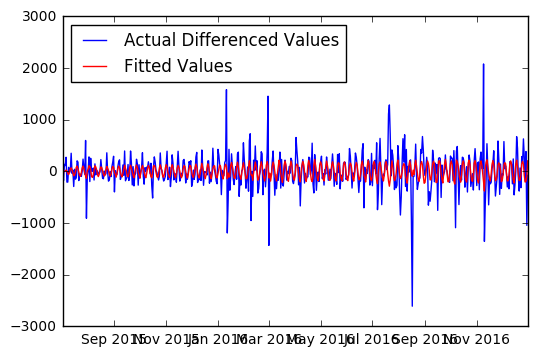

In [36]:
# Plotting  ARIMA(3 0 2) gives error
model = ARIMA(differencedEn, order=(3, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(differencedEn, label='Actual Differenced Values')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values')
plt.legend(loc='best')

In [37]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  549
Model:                     ARMA(3, 2)   Log Likelihood               -3939.378
Method:                       css-mle   S.D. of innovations            314.164
Date:                Tue, 03 Oct 2017   AIC                           7892.756
Time:                        22:04:56   BIC                           7922.912
Sample:                    07-02-2015   HQIC                          7904.541
                         - 12-31-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.3598     12.357      0.110      0.912       -22.859    25.579
ar.L1.y        1.1577      0.001    822.965      0.000         1.155     1.160
ar.L2.y       -0.8888      0.000  -2106.081      0.000        -0.890    -0.888
ar.L3.y       -0.0892      0.000   -278.735      0.000        -0.090    -0.089
ma.L1.y       -1.2424      0.018    -68.496      0.000        -1.278    -1.207
ma.L2.y        0.9981      0.032     31.115      0.000         0.935     1.061
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6235           -0.7819j            1.0000           -0.1429
AR.2            0.6235           +0.7819j            1.0000            0.1429
AR.3          -11.2147           -0.0000j           11.2147           -0.5000
MA.1            0.6223           -0.7839j            1.0009           -0.1432
MA.2            0.6223           +0.7839j            1.0009            0.1432
-----------------------------------------------------------------------------
"""

In [38]:
predictionsARIMADiff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictionsARIMADiff = predictionsARIMADiff*-1

In [39]:
predictions_ARIMA_diff_cumsum = predictionsARIMADiff.cumsum()
predictions = pd.Series(avg['en'][0], index=avg['en'].index)
predictions = predictions.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# predictions = predictions_ARIMA_diff_cumsum + avg['en'][0]


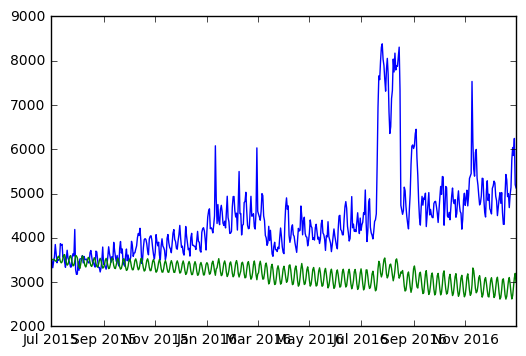

In [40]:
plt.plot(avg['en'])
plt.plot(predictions)

In [42]:
 # Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# scikit learn packages for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [56]:
X = avg['en'][0:549]
y = avg['en'][1:550]

In [57]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [59]:
 # Feature Scaling
sc = MinMaxScaler()
X_train = np.reshape(X_train,(-1,1))
y_train = np.reshape(y_train,(-1,1))
X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)

In [68]:
# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, 1)

In [72]:
# Initialising the RNN
regressor = Sequential()

# Adding the input layerand the LSTM layer
regressor.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [74]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = True)

In [75]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (165, 1, 1))
y_pred = regressor.predict(inputs)
y_pred = sc.inverse_transform(y_pred)

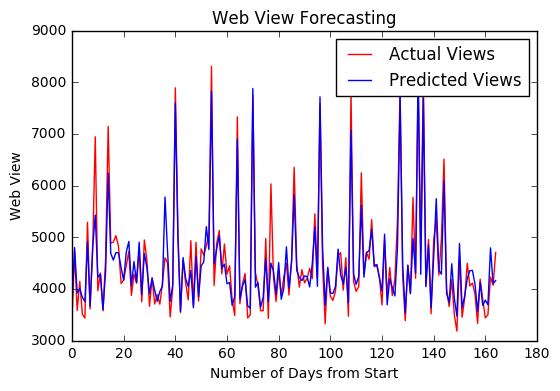

In [95]:
#Visualising Result
plt.figure
plt.plot(y_test.values, color = 'red', label = 'Actual Views')
plt.plot(y_pred.reshape(1,165)[0], color = 'blue', label = 'Predicted Views')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()